<a href="https://colab.research.google.com/github/ericodle/music_classification_project/blob/main/MFCC_intensive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script shows the step-by-step processs to generate MFCCs from a wav file for later analysis. 

Heavily borrowed from Chris Traile's "Mel Filterbanks And Mel Spectrograms" Jupyter notebook.

In [70]:
# Import dependencies. Install if necessary.
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy import fft

In [5]:
# Load in your wav file using Librosa. x represents the audio signal, and sr represents sample rate. 
# For google colab, drag-n-drop the file into the right side "Files" margin for temporary storage.
filepath = '/content/b.wav'
x, sr = librosa.load(filepath)

We will use the short-time version of the Fourier transform to generate an amplitude (dB) vs. frequency (Hz) graph.

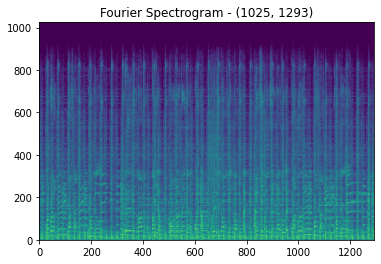

In [6]:
hop_length = 512
win_length = 2048
S = librosa.stft(x, hop_length=hop_length, win_length = win_length)
S = np.abs(S)
Sdb = librosa.amplitude_to_db(S,ref=np.max)
plt.imshow(Sdb, aspect='auto')
plt.title(f'Fourier Spectrogram - {S.shape}')
plt.gca().invert_yaxis()

Here is a coded example of where the Mel scale comes from Mels are a scale of frequency that is logarithmic with respect to the Hz scale. Mels are spaced to better fit data with the tendency of human hearing to lose resolution between tones as frequency increases.

(100, 1025)


Text(0.5, 0, 'Frequency Bin')

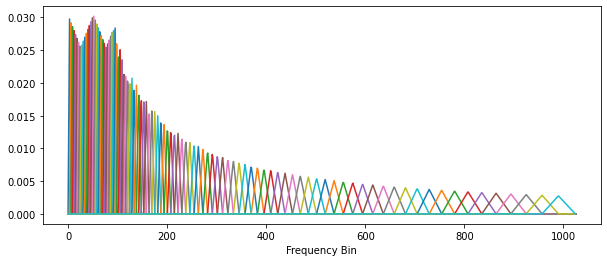

In [7]:
M = librosa.filters.mel(sr=sr, n_fft=2048, n_mels=100)
print(M.shape)
plt.figure(figsize=(10, 4))
plt.plot(M.T)
plt.xlabel("Frequency Bin")



We will matrix multiply the Mel Filterbank (100 x 1025) with the Fourier Spectrogram (1025 x 1293) to get our MFCCs. Matrix multiplication requires that the first dimension of one matrix be the same as the second dimension of the other matrix. 

Text(0.5, 1.0, 'Mel Spectrogram (100 x 1293)')

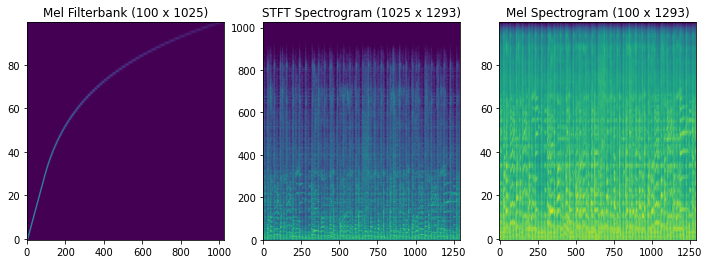

In [8]:
mel_specgram = np.log10(M.dot(S**2))
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(M, aspect='auto')
plt.title("Mel Filterbank ({} x {})".format(M.shape[0], M.shape[1]))
plt.gca().invert_yaxis()
plt.subplot(132)
plt.imshow(Sdb, aspect='auto')
plt.gca().invert_yaxis()
plt.title("STFT Spectrogram ({} x {})".format(Sdb.shape[0], Sdb.shape[1]))
plt.subplot(133)
plt.imshow(mel_specgram, aspect='auto')
plt.gca().invert_yaxis()
plt.title("Mel Spectrogram ({} x {})".format(mel_specgram.shape[0], mel_specgram.shape[1]))

Now that we have a Mel Spectrogram, we have to log it and take the Discrete Cosine Transform (DCT) to get MFCCs. 

Note that Librosa's mfcc function does all this for us by 1) calling the melspectrogram function, 2) applying a logarithmic structure to the spectrogram via the power_to_db function, 3) running the frequencies through a DCT, and 4) abbreviating the new spectrum to only the first n_mfcc coefficients.

Text(0.5, 1.0, 'Mel Spectrogram in decibles')

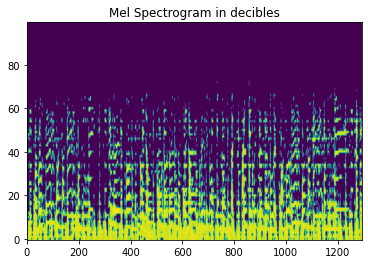

In [15]:
### Convert to log-scale (db)
mel_spec_to_db = librosa.power_to_db(mel_specgram, ref=np.max)
plt.imshow(mel_spec_to_db, aspect='auto')
plt.gca().invert_yaxis()
plt.title("Mel Spectrogram in decibles")

For simplicity, start from the original .wav file and calculate mfccs using librosa. 

(I tried to apply a dct on the above data and it was junk. This may be because the workflow to this point used the short-time Fourier transform whereas librosa uses the fast Fourier transform. Or I forgot to add a zero somewhere. If you figure it out, please let me know.)

To visualize how mfcc count affects our output, we can print three graphs.

<function matplotlib.pyplot.show>

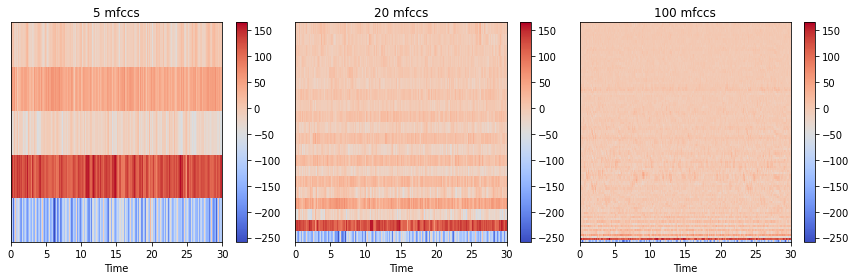

In [73]:
x, sr = librosa.load(filepath)
mfcc_low = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=5)
mfcc_med = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=20)
mfcc_high = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=100)

plt.figure(figsize=(12, 4))
plt.subplot(131)
librosa.display.specshow(mfcc_low, x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.title('5 mfccs')
plt.show

plt.subplot(132)
librosa.display.specshow(mfcc_med, x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.title('20 mfccs')
plt.show

plt.subplot(133)
librosa.display.specshow(mfcc_high, x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.title('100 mfccs')
plt.show



Here we see a key point of optimization when training a neural network to classify audio. We get a diminishing return on useful information as we increase the numner of MFCCs. 